In [1]:
import numpy as np
from numpy import linalg as la
import networkx as nx
import matplotlib.pyplot as plt
import time

import opt

SEED = 10
np.random.seed(SEED)

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy c-extensions failed.
- Try uninstalling and reinstalling numpy.
- If you have already done that, then:
  1. Check that you expected to use Python3.10 from "/bin/python3",
     and that you have no directories in your PATH or PYTHONPATH that can
     interfere with the Python and numpy version "1.17.4" you're trying to use.
  2. If (1) looks fine, you can open a new issue at
     https://github.com/numpy/numpy/issues.  Please include details on:
     - how you installed Python
     - how you installed numpy
     - your operating system
     - whether or not you have multiple versions of Python installed
     - if you built from source, your compiler versions and ideally a build log

- If you're working with a numpy git repository, try `git clean -xdf`
  (removes all files not under version control) and rebuild numpy.

Note: this error has many possible causes, so please don't comment on
an existing issue about this - open a new one instead.

Original error was: No module named 'numpy.core._multiarray_umath'


In [ ]:
# Functions
def norm_fro_err(A_hat, A_true):
    N = A_true.shape[0]
    A_true = A_true[~np.eye(N, dtype=bool)]
    A_hat = A_hat[~np.eye(N, dtype=bool)]
    A_true_n = A_true/la.norm(A_true)
    A_hat_n = A_hat/la.norm(A_hat)
    return la.norm(A_hat_n - A_true_n)


(100, 1000)


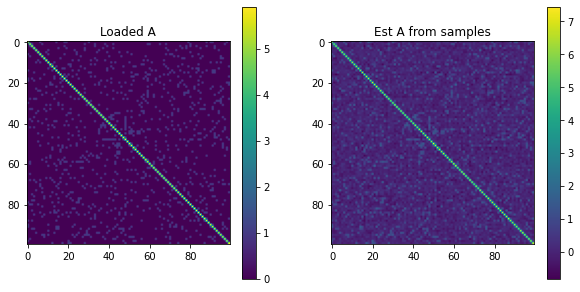

In [ ]:
# Experiment parameters
N = 100
p = .1
M = 1000

# Create Graph
graph = nx.erdos_renyi_graph(N, p, directed=False)
A = nx.to_numpy_array(graph)

# Precision matrix as loaded adjacency
max_eigenval = np.abs(la.eigvalsh(A)[0])
A_loaded = (max_eigenval + .01) * np.eye(N) + A
assert np.all(la.eigvalsh(A_loaded) >= 0), 'Precision is not a PSD matrix'

# Create GMRF signals
mean = np.zeros(N)
Cov = la.inv(A_loaded)
X = np.random.multivariate_normal(mean, Cov, size=M).T
Cov_hat = X @ X.T / M

# Create 2 sensitive groups
B = np.ones((2, N))
B[0,0:50] = 1/50
B[0,50:] = -1/50
B[1,50:100] = 1/50
B[1,0:50] = -1/50


# Plot data
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
im1 = axes[0].imshow(A_loaded)
axes[0].set_title('Loaded A')
fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(la.inv(Cov_hat))
axes[1].set_title('Est A from samples')
fig.colorbar(im2, ax=axes[1])

print(X.shape)

In [ ]:
stepsize = .02
epsilon = .5
lamb = np.log(N)/M * 10/5 #.01
beta = .1

# #####   Projected Proximal GD estimate   #####
t_i = time.time()
A_ppgd, errs_A_ppgd = opt.node_FGL_ppgd(Cov_hat, lamb, stepsize, beta, B, epsilon=epsilon,
                                        iters=10000, A_true=A_loaded)
t_solved = time.time() - t_i
print(f'Proj Prox Grad Desc solved in {t_solved:3f} secs')

#####   FISTA estimate   #####
t_i = time.time()
A_fista, errs_A_fista = opt.node_FGL_fista(Cov_hat, lamb, stepsize, beta, B, epsilon=epsilon,
                                           iters=1000, A_true=A_loaded)
t_solved = time.time() - t_i
print(f'FISTA solved in {t_solved:3f} secs')

Proj Prox Grad Desc solved in 15.485534 secs
FISTA solved in 1.694539 secs


Square fro err (naive): 0.297
Square fro err (PPGD)): 0.082
Square fro err (FISTA): 0.082


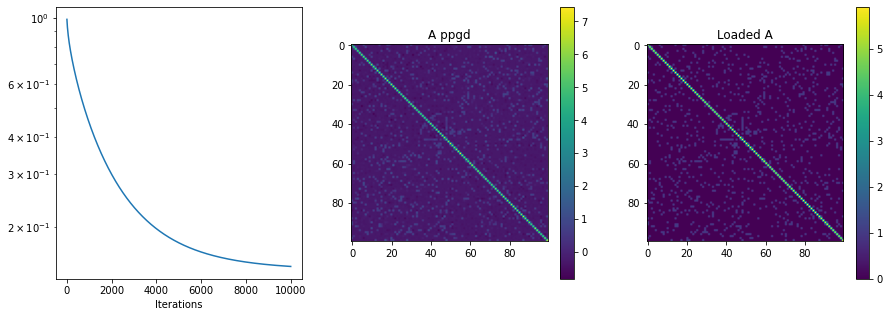

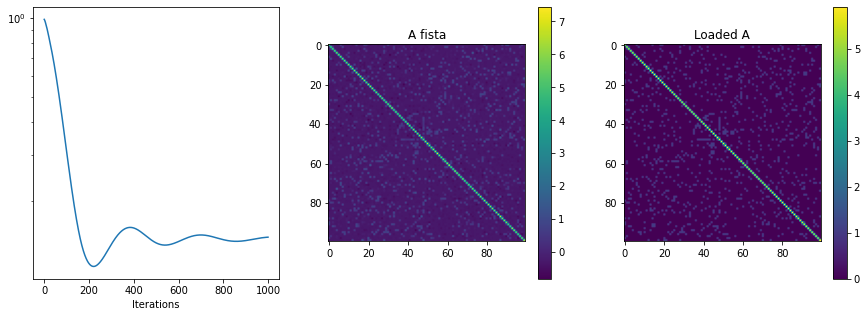

In [ ]:
err_naive = norm_fro_err(la.inv(Cov_hat), A_loaded) **2
err_ppgd = norm_fro_err(A_ppgd, A_loaded) **2
err_fista = norm_fro_err(A_fista, A_loaded) **2

print(f'Square fro err (naive): {err_naive:.3f}')
print(f'Square fro err (PPGD)): {err_ppgd:.3f}')
print(f'Square fro err (FISTA): {err_fista:.3f}')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im1 = axes[0].semilogy(errs_A_ppgd)
axes[0].set_xlabel('Err')
axes[0].set_xlabel('Iterations')
im = axes[1].imshow(A_ppgd)
axes[1].set_title('A ppgd')
fig.colorbar(im2, ax=axes[1])
im = axes[2].imshow(A_loaded)
axes[2].set_title('Loaded A')
fig.colorbar(im, ax=axes[2])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
im1 = axes[0].semilogy(errs_A_fista)
axes[0].set_xlabel('Err')
axes[0].set_xlabel('Iterations')
im = axes[1].imshow(A_fista)
axes[1].set_title('A fista')
fig.colorbar(im2, ax=axes[1])
im = axes[2].imshow(A_loaded)
axes[2].set_title('Loaded A')
fig.colorbar(im, ax=axes[2])